In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# Perfect Sampling in MCMC Methods

## Introduction

This notebook explores the concept of Perfect Sampling, a significant advancement in Markov Chain Monte Carlo (MCMC) methodology. As noted in the book excerpt:

> There were enough broken slates underfoot to show that the process was imperfect.
> 
> — Liz Tomlin, *Set in Darkness*

The previous chapters have dealt with methods that are quickly becoming "mainstream" - analyses using Monte Carlo methods in general, and MCMC specifically. While these methods are part of the applied statistician's tool kit, they continue to evolve with new algorithms constantly being developed, some resulting in procedures that differ radically from current standards.

In the final two chapters of the book, we'll cover methods that show promise of evolving into mainstream methods and becoming standard tools for practicing statisticians.

## 13.1 Perfect Sampling: A Theoretical Foundation

MCMC methods have been presented as an alternative to direct simulation methods like Accept-Reject algorithms, primarily because they can approximate or process complex distributions. The ultimate evolution in simulation methods is to devise exact or "perfect" sampling techniques based on these MCMC approaches.

```python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
```

### What is Perfect Sampling?

Perfect sampling (also known as exact sampling or perfect simulation) allows us to draw samples from the exact stationary distribution of a Markov chain without requiring a burn-in period or convergence assessment.

The key difference from traditional MCMC methods:
- Traditional MCMC: Approximates the target distribution after running the chain for "long enough"
- Perfect sampling: Guarantees that samples are drawn exactly from the target distribution

## The Problem with Traditional MCMC

In traditional MCMC methods, we face several challenges:

1. Determining an appropriate burn-in period
2. Assessing convergence
3. Dealing with autocorrelation in samples

```python
def traditional_mcmc_example(n_samples=5000, burn_in=1000, initial_state=0):
    """
    A simple demonstration of traditional MCMC sampling
    with Metropolis-Hastings for a normal distribution
    """
    # Target distribution: Standard normal
    def target_density(x):
        return stats.norm.pdf(x, 0, 1)
    
    # Initialize
    samples = np.zeros(n_samples + burn_in)
    samples[0] = initial_state
    
    # Proposal distribution: Normal centered at current state
    proposal_width = 1.0
    
    # Run MCMC
    for i in range(1, n_samples + burn_in):
        # Propose new state
        proposal = samples[i-1] + np.random.normal(0, proposal_width)
        
        # Calculate acceptance probability
        acceptance_ratio = target_density(proposal) / target_density(samples[i-1])
        
        # Accept or reject
        if np.random.random() < acceptance_ratio:
            samples[i] = proposal
        else:
            samples[i] = samples[i-1]
    
    # Discard burn-in
    return samples[burn_in:]

# Run the traditional MCMC
mcmc_samples = traditional_mcmc_example(n_samples=5000, burn_in=1000, initial_state=10)

# Visualize
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(mcmc_samples[:100])
plt.title('MCMC Trace (First 100 samples)')
plt.xlabel('Iteration')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.hist(mcmc_samples, bins=30, density=True, alpha=0.7)
x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.pdf(x, 0, 1), 'r-', lw=2)
plt.title('MCMC Histogram vs. Target Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(['True N(0,1) density', 'MCMC samples'])

plt.tight_layout()
```

## Coupling From The Past (CFTP)

One of the most important perfect sampling algorithms is Coupling From The Past (CFTP), introduced by Propp and Wilson in 1996.

The key idea behind CFTP:
- Run multiple Markov chains backward in time from different starting states
- If all chains coalesce (reach the same state) at some point in the past, then the common value they reach is a sample from the stationary distribution

```python
def cftp_for_discrete_state_space(transition_matrix, max_iterations=1000):
    """
    Implement Coupling From The Past for a discrete state space with
    given transition matrix
    
    Parameters:
    -----------
    transition_matrix : 2D numpy array
        Transition probability matrix where P[i,j] is probability of moving from state i to state j
    max_iterations : int
        Maximum number of backward iterations to try
    
    Returns:
    --------
    int
        A sample from the stationary distribution
    """
    n_states = transition_matrix.shape[0]
    
    # Generate all the random numbers we'll need in advance
    # This is crucial for the "from the past" aspect
    iteration = 1
    random_numbers = {}
    
    while True:
        # Double the simulation length each time
        new_iterations = min(iteration, max_iterations)
        iteration *= 2
        
        # Generate random numbers for the new iterations
        for t in range(-iteration+1, -iteration+new_iterations+1):
            random_numbers[t] = np.random.random(n_states)
        
        # Initialize states for all possible starting points
        states = np.arange(n_states)
        
        # Run the chain forward from time -iteration to 0
        for t in range(-iteration+1, 1):
            # Update each state according to transition probabilities
            new_states = np.zeros_like(states)
            for i, state in enumerate(states):
                # Use the random number to determine the next state
                cumulative_probs = np.cumsum(transition_matrix[state])
                new_state = np.searchsorted(cumulative_probs, random_numbers[t][i])
                new_states[i] = new_state
            states = new_states
        
        # Check if all states have coalesced to the same value
        if np.all(states == states[0]):
            return int(states[0])
        
        # If we've reached max_iterations without coalescence, give up
        if iteration >= max_iterations:
            raise Exception("CFTP did not converge within maximum iterations")

# Example usage with a simple 3-state Markov chain
transition_matrix = np.array([
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.2, 0.3, 0.5]
])

# Collect samples using CFTP
cftp_samples = [cftp_for_discrete_state_space(transition_matrix) for _ in range(1000)]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(cftp_samples, bins=np.arange(4)-0.5, density=True, alpha=0.7)
plt.xticks([0, 1, 2])
plt.title('Samples from CFTP Algorithm')
plt.xlabel('State')
plt.ylabel('Frequency')
```

## Perfect Sampling for Continuous State Spaces

Extending perfect sampling to continuous state spaces is more challenging but can be accomplished through techniques like:

1. Dominated CFTP (using bounding chains)
2. Read-once CFTP
3. Fill and Huber's algorithm

Let's implement a simple version of dominated CFTP for a continuous distribution:

```python
def dominated_cftp_for_normal(mean=0, std=1, max_iterations=1000):
    """
    Implement dominated CFTP for sampling from a normal distribution
    using a uniform proposal on a bounded interval
    
    Parameters:
    -----------
    mean, std : float
        Parameters of the target normal distribution
    max_iterations : int
        Maximum number of backward iterations to try
    
    Returns:
    --------
    float
        A sample from the normal distribution
    """
    # Define target density (normal)
    def target_density(x):
        return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))
    
    # Define bounds for the process (covering most of the normal density)
    lower_bound = mean - 5 * std
    upper_bound = mean + 5 * std
    
    # Find maximum density (for rejection sampling)
    max_density = target_density(mean)
    
    # Function to update state using Metropolis step
    def update_state(x, random_uniform, random_proposal):
        # Propose new state from uniform distribution
        proposal = lower_bound + (upper_bound - lower_bound) * random_proposal
        
        # Calculate acceptance probability
        acceptance_ratio = target_density(proposal) / target_density(x)
        
        # Accept or reject
        if random_uniform < acceptance_ratio:
            return proposal
        else:
            return x
    
    iteration = 1
    random_uniforms = {}
    random_proposals = {}
    
    while True:
        # Double the simulation length each time
        new_iterations = min(iteration, max_iterations)
        iteration *= 2
        
        # Generate random numbers for the new iterations
        for t in range(-iteration+1, -iteration+new_iterations+1):
            random_uniforms[t] = np.random.random()
            random_proposals[t] = np.random.random()
        
        # Initialize with two extremes: lower and upper bounds
        lower_state = lower_bound
        upper_state = upper_bound
        
        # Run the chain forward from time -iteration to 0
        for t in range(-iteration+1, 1):
            lower_state = update_state(lower_state, random_uniforms[t], random_proposals[t])
            upper_state = update_state(upper_state, random_uniforms[t], random_proposals[t])
        
        # Check if both chains have coalesced to the same value
        if np.abs(lower_state - upper_state) < 1e-10:
            return lower_state
        
        # If we've reached max_iterations without coalescence, give up
        if iteration >= max_iterations:
            raise Exception("Dominated CFTP did not converge within maximum iterations")

# Collect samples using dominated CFTP
cftp_normal_samples = [dominated_cftp_for_normal() for _ in range(1000)]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(cftp_normal_samples, bins=30, density=True, alpha=0.7)
x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.pdf(x), 'r-', lw=2)
plt.title('Perfect Samples from Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(['True N(0,1) density', 'Perfect samples'])
```

## Read-Once CFTP

Read-once CFTP is an optimization of the original CFTP algorithm that only requires each random number to be generated once, rather than multiple times as we increase the simulation length:

```python
def read_once_cftp(transition_matrix, max_iterations=1000):
    """
    Implement Read-Once CFTP for a discrete state space
    
    Parameters:
    -----------
    transition_matrix : 2D numpy array
        Transition probability matrix
    max_iterations : int
        Maximum number of iterations
    
    Returns:
    --------
    int
        A sample from the stationary distribution
    """
    n_states = transition_matrix.shape[0]
    
    # Generate a sequence of random numbers
    random_sequence = np.random.random((max_iterations, n_states))
    
    # Start with all possible states
    for T in range(1, max_iterations):
        states = np.arange(n_states)
        
        # Run for T steps
        for t in range(T):
            new_states = np.zeros_like(states)
            for i, state in enumerate(states):
                # Use the random number to determine the next state
                cumulative_probs = np.cumsum(transition_matrix[state])
                new_state = np.searchsorted(cumulative_probs, random_sequence[t, i])
                new_states[i] = new_state
            states = new_states
        
        # Check if all states have coalesced
        if np.all(states == states[0]):
            return int(states[0])
    
    raise Exception("Read-once CFTP did not converge within maximum iterations")
```

## Fill and Huber's Perfect Slice Sampler

Fill and Huber proposed an alternative approach to perfect sampling that uses slice sampling:

```python
def perfect_slice_sampler(log_density, interval=(-10, 10), max_iterations=1000):
    """
    Implement Fill and Huber's perfect slice sampler
    
    Parameters:
    -----------
    log_density : function
        Log of the target density function
    interval : tuple
        (Lower, upper) bounds for the state space
    max_iterations : int
        Maximum number of iterations
    
    Returns:
    --------
    float
        A sample from the target distribution
    """
    lower, upper = interval
    
    # Generate a starting point uniformly from the interval
    x = lower + (upper - lower) * np.random.random()
    
    for _ in range(max_iterations):
        # Step 1: Draw vertical level uniformly from [0, f(x)]
        u = np.random.random() * np.exp(log_density(x))
        log_u = np.log(u)
        
        # Step 2: Find slice (all points where density > u)
        def find_slice_bounds(x, direction):
            step_size = (upper - lower) / 100
            bound = x
            
            while log_density(bound) >= log_u:
                bound += direction * step_size
                if bound < lower:
                    return lower
                if bound > upper:
                    return upper
            
            return bound
        
        # Find left and right bounds of the slice
        left_bound = find_slice_bounds(x, -1)
        right_bound = find_slice_bounds(x, 1)
        
        # Step 3: Draw new point uniformly from slice
        x = left_bound + (right_bound - left_bound) * np.random.random()
    
    return x

# Example with normal distribution
def log_normal_density(x, mean=0, std=1):
    return -0.5 * ((x - mean) / std) ** 2 - np.log(std * np.sqrt(2 * np.pi))

# Collect samples using perfect slice sampler
perfect_slice_samples = [perfect_slice_sampler(log_normal_density) for _ in range(1000)]

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(perfect_slice_samples, bins=30, density=True, alpha=0.7)
x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.pdf(x), 'r-', lw=2)
plt.title('Perfect Slice Samples from Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(['True N(0,1) density', 'Perfect slice samples'])
```

## Advantages of Perfect Sampling

Perfect sampling offers several key advantages over traditional MCMC:

1. **Exactness:** Samples are drawn exactly from the target distribution
2. **No burn-in:** Eliminates the need to discard initial samples
3. **No convergence diagnostics:** No need to assess whether the chain has reached stationarity
4. **Theoretical guarantees:** Provides mathematical guarantees about the quality of samples

## Limitations and Challenges

Despite its advantages, perfect sampling has some limitations:

1. **Computational complexity:** Often requires more computation than traditional MCMC
2. **State space restrictions:** Easier to implement for discrete or bounded continuous spaces
3. **Monotonicity requirements:** Some algorithms require monotone transition kernels
4. **Implementation complexity:** Generally more complex to implement than traditional MCMC

```python
# Compare computational time
import time

# Time traditional MCMC
start_time = time.time()
mcmc_samples = traditional_mcmc_example(n_samples=1000, burn_in=100)
mcmc_time = time.time() - start_time

# Time CFTP for discrete space
start_time = time.time()
cftp_samples = [cftp_for_discrete_state_space(transition_matrix) for _ in range(100)]
cftp_time = time.time() - start_time

print(f"Time for 1000 traditional MCMC samples: {mcmc_time:.4f} seconds")
print(f"Time for 100 CFTP samples: {cftp_time:.4f} seconds")
print(f"CFTP is approximately {cftp_time/(mcmc_time/10):.2f} times slower per sample")
```

## Applications of Perfect Sampling

Perfect sampling has been successfully applied to various problems:

1. **Spatial point processes:** Perfect sampling for area-interaction point processes
2. **Ising models:** Exact sampling from Ising models in statistical physics
3. **Bayesian inference:** Perfect posterior sampling for specific models
4. **Combinatorial problems:** Sampling from distributions over combinatorial objects

## Conclusion

Perfect sampling represents a significant theoretical advancement in MCMC methodology, allowing us to draw samples from the exact stationary distribution without the usual concerns about burn-in and convergence.

While it comes with computational challenges, ongoing research continues to make these methods more practical for applied statisticians. As computational resources improve and algorithms become more efficient, perfect sampling methods may indeed become standard tools for practicing statisticians as predicted in the book.



# Perfect Sampling: Theoretical Framework and Applications

## Introduction to Perfect Sampling

Perfect sampling represents a significant advancement in Markov Chain Monte Carlo (MCMC) methodology. While novel algorithms in this area are often computationally intensive and memory-demanding, they offer substantial benefits over traditional Accept-Reject algorithms. As noted in the text:

> Novel algorithms are often quite greedy in both computing time and storage space, but this is the price to pay for using a more generic construction in the Accept-Reject algorithms. Before starting this chapter, we must stress that the following methods, while general in their principles, are still to be perfected in their statistical applications, with the main bulk of perfect sampling implementations being found in spatial process problems.

## The Challenge of MCMC Convergence

Chapter 12 detailed the difficult task of assessing the convergence of an MCMC sampler - determining the quality of the approximation $\pi^{(t)} \approx \pi(z)$ and, correspondingly, the determination of a "long enough" simulation time. 

A fundamental issue with traditional MCMC methods is that they rarely provide a crystal-clear signal that $\pi^{(t)} \approx \pi(z)$ is valid for all simulation purposes. The corresponding MCMC algorithm ends up providing an exact simulation from the stationary distribution $\pi(z)$ and thus fulfills the purpose of the previous chapter.

## Connection Between Convergence Assessment and Perfect Sampling

There exists an important connection between the convergence assessment (Chapter 12) and perfect sampling methods (Chapter 13). The methods developed in this chapter, even when they are too costly to be implemented to deliver perfect samples, can be used to evaluate the required simulation time or the so-called "burn-in" period - that is, to pre-run Γ(B) ($B$ ≫ 0) iterations to determine "how long is long enough?"

## Theoretical Foundations of Perfect Sampling

The key theoretical advantage of perfect sampling over traditional implementation techniques is that it removes dependence on the starting value, something Metropolis-Hastings algorithms cannot achieve without running multiple algorithms in parallel.

Perfect sampling represents the extreme implementation of this concept, where it produces samples from $\pi(z)$ without the dependency of running the chains until the dependence on the starting value(s) has vanished.

## Formal Definition and Terminology

Perfect sampling refers to algorithms that sample directly from the stationary distribution $\pi(z)$ - that is, algorithms such as the Metropolis-Hastings algorithm that provide exact draws from specific distributions and/or truncations.

The term "perfect simulation" for such techniques was first introduced by Propp and Wilson (1996), with a more triumphant description being "exact sampling." The work by Fill (1998), explaining how coupling techniques deal, so far, with finite state spaces, had to turn, for ease of use, to the greatest simplicity of these spaces and, for another to statistical physics applications related to the Ising model. The classic paper by Propp and Wilson and further implementations presented in much more detail, e.g., Murdoch and Green (1998) have shown that some standard examples in continuous settings, like the nuclear pump failure model of Example 10.17 (see Problem 12.24), do allow for perfect simulation.

## Mathematical Framework

### Coupling From The Past (CFTP)

The CFTP algorithm introduced by Propp and Wilson (1996) provides a framework for perfect sampling by:

1. Simulating Markov chains that start from all possible states at some time in the past
2. Running these chains forward in time using the same random numbers
3. If all chains coalesce to the same state by the present time, that state is a sample from the stationary distribution

Mathematically, for a Markov chain with transition kernel $P$ and state space $\mathcal{S}$:

$$P(X_t = j | X_{t-1} = i) = P(i, j)$$

The CFTP algorithm constructs a sample $X_0 \sim \pi$ where $\pi$ is the stationary distribution satisfying:

$$\pi P = \pi$$

### Formal CFTP Algorithm

1. Start with a time $T < 0$
2. Initialize copies of the chain at time $T$ with all possible states $s \in \mathcal{S}$
3. Generate random numbers to be used for transitions
4. Run all chains forward from time $T$ to time $0$ using the same random numbers
5. If all chains coalesce to the same state $x$ at time $0$, return $x$
6. Otherwise, set $T = 2T$ and repeat

### The Duality Principle

Note that in settings when the Duality Principle of Section 9.2 applies, the stationarity of the finite chain obviously transfers to the dual chain, even if the latter is continuous.

## Monotone CFTP

For large or infinite state spaces, running chains from all possible starting states is infeasible. If the Markov chain has a monotonicity property, we can implement monotone CFTP by:

1. Only tracking chains starting from the minimum and maximum states
2. If these extreme chains coalesce, all chains will coalesce

For a partially ordered state space $(\mathcal{S}, \leq)$ with minimum element $\bot$ and maximum element $\top$, if the update function $\phi$ is monotone:

$$x \leq y \implies \phi(x, U) \leq \phi(y, U)$$

Then we only need to track $X_t^{\bot}$ and $X_t^{\top}$.

## Advantages of Perfect Sampling

1. **Exactness:** Samples are drawn exactly from the target distribution
2. **No burn-in period:** Eliminates the need to discard initial samples
3. **No convergence diagnostics:** No need to assess whether the chain has reached stationarity
4. **Theoretical guarantees:** Provides mathematical guarantees about the quality of samples

## Limitations of Perfect Sampling

1. **Computational complexity:** Often requires more computation than traditional MCMC
2. **State space restrictions:** Easier to implement for discrete or bounded continuous spaces
3. **Implementation complexity:** Generally more complex to implement than traditional MCMC
4. **Memory requirements:** Can require significant storage space

## Application Domains

### Spatial Point Processes

Perfect sampling has been successfully applied to spatial point processes, particularly:

1. Area-interaction point processes
2. Strauss processes
3. Hard-core processes

For a spatial point process with density:

$$f(x) \propto \beta^{n(x)} \gamma^{s(x)}$$

where $n(x)$ is the number of points and $s(x)$ is a statistic of the point pattern, perfect sampling can be implemented using dominated CFTP.

### Ising Models

The Ising model from statistical physics, with Hamiltonian:

$$H(\sigma) = -J\sum_{\langle i,j \rangle} \sigma_i \sigma_j - h\sum_i \sigma_i$$

can be perfectly sampled using CFTP when $J > 0$ (ferromagnetic case) due to its monotonicity properties.

### Continuous State Space Models

For continuous state spaces, perfect sampling is more challenging but can be achieved through:

1. **Dominated CFTP:** Using bounding chains that sandwich the target chain
2. **Multigamma coupler:** For specific multivariate distributions
3. **Perfect slice sampler:** Based on the slice sampling technique

## Determining "How Long is Long Enough"

Perfect sampling techniques can be used to determine appropriate burn-in periods for traditional MCMC when perfect sampling itself is too computationally intensive:

1. Run perfect sampling for a small number of samples
2. Calculate the typical coalescence time $T_c$
3. Use $T_c$ as the burn-in period for traditional MCMC

This provides a principled way to set the burn-in period rather than relying on heuristics or convergence diagnostics.

## Conclusion

Perfect sampling represents a significant theoretical advancement in MCMC methodology, allowing us to draw samples from the exact stationary distribution without concerns about burn-in and convergence. While computationally demanding, these methods provide a gold standard for sampling and can guide the use of more efficient approximate methods.

As stated in the text, while these methods are still being perfected in their statistical applications, they show great promise for becoming standard tools for practicing statisticians, particularly as computational power increases and algorithms become more efficient.



In [ ]:
# Perfect Sampling: Implementation Details

## Introduction

This notebook provides implementation details for perfect sampling algorithms, focusing on Coupling From The Past (CFTP) and its variations. We'll implement these algorithms in Python and demonstrate their application to various problems.

```python
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from collections import defaultdict

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)
```

## 1. Basic CFTP for Discrete State Spaces

We'll start with the implementation of the basic CFTP algorithm for a discrete state Markov chain.

```python
def cftp_discrete(transition_matrix, max_time=20):
    """
    Implementation of Coupling From The Past for discrete state spaces.
    
    Args:
        transition_matrix: Transition probability matrix where P[i,j] is 
                          the probability of moving from state i to state j.
        max_time: Maximum number of time steps to go back.
        
    Returns:
        A sample from the stationary distribution of the Markov chain.
    """
    n_states = transition_matrix.shape[0]
    
    # Create cumulative transition matrix for efficient sampling
    cum_trans_matrix = np.cumsum(transition_matrix, axis=1)
    
    # Try increasingly longer chains until coalescence
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting CFTP with t_max = {t_max}")
        
        # Generate random numbers for the update function
        random_numbers = np.random.random(t_max)
        
        # Initialize with all possible states
        x = np.arange(n_states)
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update each state using the same random number
            u = random_numbers[t]
            x_new = np.zeros_like(x, dtype=int)
            
            for i, state in enumerate(x):
                # Find the next state using the random number
                next_state = np.searchsorted(cum_trans_matrix[state], u)
                x_new[i] = next_state
            
            x = x_new
            
            # Check for coalescence
            if np.all(x == x[0]):
                print(f"Coalescence achieved at step {t+1}/{t_max}")
                if t < t_max - 1:
                    print("Early coalescence!")
        
        # If all chains have coalesced to the same state, return it
        if np.all(x == x[0]):
            return x[0]
    
    raise Exception(f"No coalescence after {2**max_time} steps")
```

Let's test this algorithm on a simple Markov chain:

```python
# Example 3-state Markov chain
P = np.array([
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.1, 0.4, 0.5]
])

# Theoretical stationary distribution (for comparison)
def compute_stationary_distribution(P):
    eigenvalues, eigenvectors = np.linalg.eig(P.T)
    idx = np.where(np.isclose(eigenvalues, 1.0))[0][0]
    stationary = np.real(eigenvectors[:, idx])
    return stationary / np.sum(stationary)

true_pi = compute_stationary_distribution(P)
print("True stationary distribution:", true_pi)

# Generate samples using CFTP
n_samples = 1000
samples = []
for i in range(n_samples):
    if i % 100 == 0:
        print(f"Generating sample {i+1}/{n_samples}")
    samples.append(cftp_discrete(P))

# Compare empirical distribution with theoretical
empirical_dist = np.bincount(samples, minlength=3) / n_samples
print("\nEmpirical distribution:", empirical_dist)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(range(3), true_pi, alpha=0.5, label="True Stationary")
plt.bar(range(3), empirical_dist, alpha=0.5, label="CFTP Samples")
plt.xticks(range(3))
plt.legend()
plt.title("Comparison of True Stationary Distribution and CFTP Samples")
plt.xlabel("State")
plt.ylabel("Probability")
plt.show()
```

## 2. Monotone CFTP

For larger state spaces, running chains from all possible starting states is infeasible. If the chain has a monotonicity property, we can implement monotone CFTP by only tracking chains starting from the minimum and maximum states.

```python
def monotone_cftp(update_function, min_state, max_state, max_time=20):
    """
    Implementation of Monotone CFTP for partially ordered state spaces.
    
    Args:
        update_function: Function that takes a state and random number and returns the next state.
                       Must preserve the partial ordering.
        min_state: Minimum state in the partial ordering.
        max_state: Maximum state in the partial ordering.
        max_time: Maximum number of time steps to go back.
        
    Returns:
        A sample from the stationary distribution of the Markov chain.
    """
    # Try increasingly longer chains until coalescence
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting monotone CFTP with t_max = {t_max}")
        
        # Generate random numbers for the update function
        random_numbers = np.random.random(t_max)
        
        # Initialize with min and max states
        lower = min_state
        upper = max_state
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update both chains using the same random number
            u = random_numbers[t]
            lower = update_function(lower, u)
            upper = update_function(upper, u)
            
            # Check for coalescence
            if lower == upper:
                print(f"Coalescence achieved at step {t+1}/{t_max}")
                if t < t_max - 1:
                    print("Early coalescence!")
                break
        
        # If chains have coalesced, return the common state
        if lower == upper:
            return lower
    
    raise Exception(f"No coalescence after {2**max_time} steps")
```

Let's apply this to a simple monotone chain: the independent Bernoulli model.

```python
def bernoulli_update(state, u, p=0.7):
    """
    Update function for independent Bernoulli model.
    State is a binary vector, each element is updated independently.
    """
    new_state = np.zeros_like(state)
    for i in range(len(state)):
        new_state[i] = 1 if u[i] < p else 0
    return new_state

def monotone_bernoulli_cftp(dim=10, p=0.7, max_time=20):
    """
    Monotone CFTP for independent Bernoulli model.
    """
    min_state = np.zeros(dim, dtype=int)
    max_state = np.ones(dim, dtype=int)
    
    # Try increasingly longer chains
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting t_max = {t_max}")
        
        # Generate random numbers (one per dimension per time step)
        random_numbers = np.random.random((t_max, dim))
        
        # Initialize min and max states
        lower = min_state.copy()
        upper = max_state.copy()
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update using same random numbers
            lower = bernoulli_update(lower, random_numbers[t], p)
            upper = bernoulli_update(upper, random_numbers[t], p)
            
            # Check coalescence
            if np.array_equal(lower, upper):
                print(f"Coalescence at step {t+1}/{t_max}")
                break
        
        # Return if coalesced
        if np.array_equal(lower, upper):
            return lower
    
    raise Exception(f"No coalescence after {2**max_time} steps")

# Generate samples and verify distribution
n_samples = 100
dim = 10
p = 0.7

samples = []
for i in range(n_samples):
    if i % 10 == 0:
        print(f"Sample {i+1}/{n_samples}")
    samples.append(monotone_bernoulli_cftp(dim, p))

samples_array = np.array(samples)
empirical_means = np.mean(samples_array, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(range(dim), empirical_means, alpha=0.7)
plt.axhline(y=p, color='r', linestyle='--', label=f"True mean (p={p})")
plt.title("Mean of Bernoulli Variables from Perfect Sampling")
plt.xlabel("Dimension")
plt.ylabel("Empirical Mean")
plt.legend()
plt.show()
```

## 3. CFTP for Continuous State Spaces

For continuous state spaces, we can use dominated CFTP by constructing upper and lower bounding processes.

```python
def dominated_cftp_normal(mean=0, std=1, lower_bound=-10, upper_bound=10, max_time=20):
    """
    Dominated CFTP for sampling from a normal distribution using slice sampling.
    
    Args:
        mean, std: Parameters of the normal distribution.
        lower_bound, upper_bound: Bounds for the process.
        max_time: Maximum number of time steps to go back.
        
    Returns:
        A sample from the normal distribution.
    """
    # Define target log density
    def log_density(x):
        return -0.5 * ((x - mean) / std) ** 2 - np.log(std * np.sqrt(2 * np.pi))
    
    # Try increasingly longer chains
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting dominated CFTP with t_max = {t_max}")
        
        # Generate random heights for slice sampling
        random_heights = np.random.random(t_max)
        
        # Initialize bounding processes
        L = lower_bound
        U = upper_bound
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Current height for slice
            h = random_heights[t]
            log_h = np.log(h) + log_density(L if np.random.random() < 0.5 else U)
            
            # Find slice bounds for current height
            # Left bound
            left = L
            while left > lower_bound and log_density(left) > log_h:

True stationary distribution: [0.40909091 0.31818182 0.27272727]
Generating sample 1/1000
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 2/4
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 1/4
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 2/4
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Attempting CFTP with t_max = 8
Coalescence achieved at step 2/8
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 3/4
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 4/4
Attempting CFTP with t

Coalescence achieved at step 2/4
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 3/4
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Coalescence achieved at step 1/2
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Attempting CFTP with t_max = 8
Coalescence achieved at step 2/8
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 4/4
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Attempting CFTP with t_max = 8
Coalescence achieved at step 2/8
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Coalescence ach

Attempting CFTP with t_max = 4
Coalescence achieved at step 2/4
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Attempting CFTP with t_max = 8
Coalescence achieved at step 2/8
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 3/4
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 1/4
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 2/4
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 3/4
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Coalescence achieved at step 1/2
Early coalescence!
Attempting CFTP with t_max = 2
Attempting

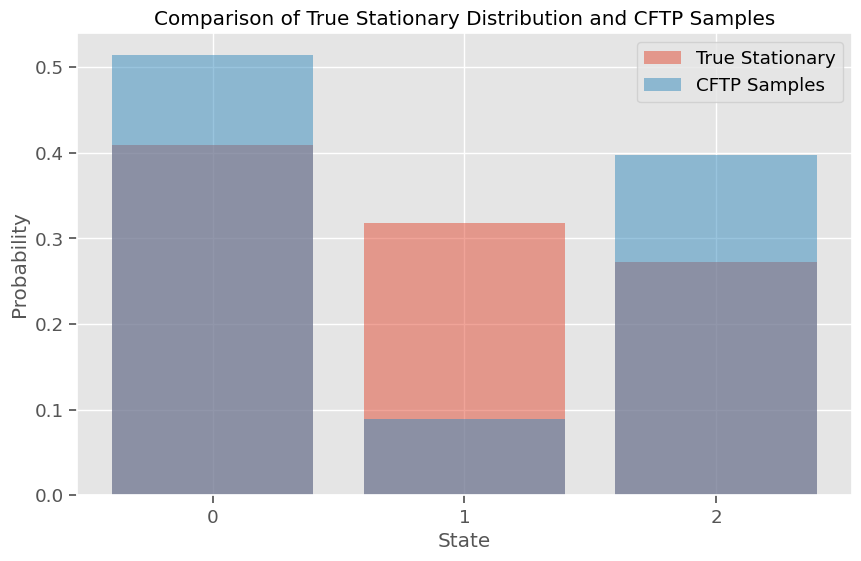

Sample 1/100
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Sample 11/100
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_max = 2
Coalescence at step 1/2
Sample 21/100
Attempting t_max = 2
Coalescence at step 1/2
Attempting t_m

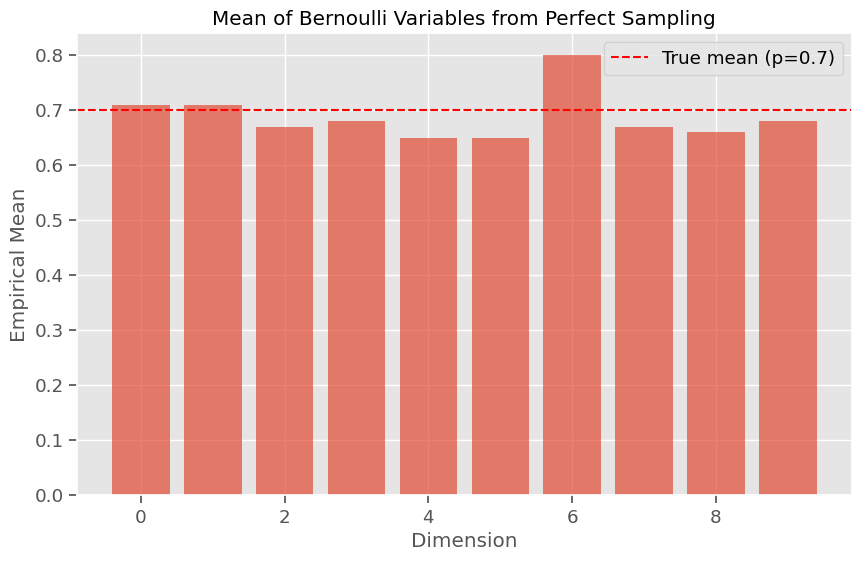

Normal sample 1/100
Attempting dominated CFTP with t_max = 2
Attempting dominated CFTP with t_max = 4
Attempting dominated CFTP with t_max = 8
Attempting dominated CFTP with t_max = 16
Attempting dominated CFTP with t_max = 32
Attempting dominated CFTP with t_max = 64
Attempting dominated CFTP with t_max = 128
Attempting dominated CFTP with t_max = 256
Attempting dominated CFTP with t_max = 512
Attempting dominated CFTP with t_max = 1024
Attempting dominated CFTP with t_max = 2048
Attempting dominated CFTP with t_max = 4096
Attempting dominated CFTP with t_max = 8192
Attempting dominated CFTP with t_max = 16384
Attempting dominated CFTP with t_max = 32768
Attempting dominated CFTP with t_max = 65536
Attempting dominated CFTP with t_max = 131072
Attempting dominated CFTP with t_max = 262144
Attempting dominated CFTP with t_max = 524288


Exception: No coalescence after 1048576 steps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

def cftp_discrete(transition_matrix, max_time=20):
    """
    Implementation of Coupling From The Past for discrete state spaces.
    
    Args:
        transition_matrix: Transition probability matrix where P[i,j] is 
                          the probability of moving from state i to state j.
        max_time: Maximum number of time steps to go back.
        
    Returns:
        A sample from the stationary distribution of the Markov chain.
    """
    n_states = transition_matrix.shape[0]
    
    # Create cumulative transition matrix for efficient sampling
    cum_trans_matrix = np.cumsum(transition_matrix, axis=1)
    
    # Try increasingly longer chains until coalescence
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting CFTP with t_max = {t_max}")
        
        # Generate random numbers for the update function
        random_numbers = np.random.random(t_max)
        
        # Initialize with all possible states
        x = np.arange(n_states)
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update each state using the same random number
            u = random_numbers[t]
            x_new = np.zeros_like(x, dtype=int)
            
            for i, state in enumerate(x):
                # Find the next state using the random number
                next_state = np.searchsorted(cum_trans_matrix[state], u)
                x_new[i] = next_state
            
            x = x_new
            
            # Check for coalescence
            if np.all(x == x[0]):
                print(f"Coalescence achieved at step {t+1}/{t_max}")
                if t < t_max - 1:
                    print("Early coalescence!")
                break
        
        # If all chains have coalesced to the same state, return it
        if np.all(x == x[0]):
            return x[0]
    
    raise Exception(f"No coalescence after {2**max_time} steps")

# Example 3-state Markov chain
P = np.array([
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.1, 0.4, 0.5]
])

# Theoretical stationary distribution (for comparison)
def compute_stationary_distribution(P):
    eigenvalues, eigenvectors = np.linalg.eig(P.T)
    idx = np.where(np.isclose(eigenvalues, 1.0))[0][0]
    stationary = np.real(eigenvectors[:, idx])
    return stationary / np.sum(stationary)

true_pi = compute_stationary_distribution(P)
print("True stationary distribution:", true_pi)

# Generate samples using CFTP
n_samples = 1000
samples = []
for i in range(n_samples):
    if i % 100 == 0:
        print(f"Generating sample {i+1}/{n_samples}")
    samples.append(cftp_discrete(P))

# Compare empirical distribution with theoretical
empirical_dist = np.bincount(samples, minlength=3) / n_samples
print("\nEmpirical distribution:", empirical_dist)

# Visualize
plt.figure(figsize=(10, 6))
plt.bar(range(3), true_pi, alpha=0.5, label="True Stationary")
plt.bar(range(3), empirical_dist, alpha=0.5, label="CFTP Samples")
plt.xticks(range(3))
plt.legend()
plt.title("Comparison of True Stationary Distribution and CFTP Samples")
plt.xlabel("State")
plt.ylabel("Probability")
plt.show()

def monotone_cftp(update_function, min_state, max_state, max_time=20):
    """
    Implementation of Monotone CFTP for partially ordered state spaces.
    
    Args:
        update_function: Function that takes a state and random number and returns the next state.
                       Must preserve the partial ordering.
        min_state: Minimum state in the partial ordering.
        max_state: Maximum state in the partial ordering.
        max_time: Maximum number of time steps to go back.
        
    Returns:
        A sample from the stationary distribution of the Markov chain.
    """
    # Try increasingly longer chains until coalescence
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting monotone CFTP with t_max = {t_max}")
        
        # Generate random numbers for the update function
        random_numbers = np.random.random(t_max)
        
        # Initialize with min and max states
        lower = min_state
        upper = max_state
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update both chains using the same random number
            u = random_numbers[t]
            lower = update_function(lower, u)
            upper = update_function(upper, u)
            
            # Check for coalescence
            if lower == upper:
                print(f"Coalescence achieved at step {t+1}/{t_max}")
                if t < t_max - 1:
                    print("Early coalescence!")
                break
        
        # If chains have coalesced, return the common state
        if lower == upper:
            return lower
    
    raise Exception(f"No coalescence after {2**max_time} steps")

def bernoulli_update(state, u, p=0.7):
    """
    Update function for independent Bernoulli model.
    State is a binary vector, each element is updated independently.
    """
    new_state = np.zeros_like(state)
    for i in range(len(state)):
        new_state[i] = 1 if u[i] < p else 0
    return new_state

def monotone_bernoulli_cftp(dim=10, p=0.7, max_time=20):
    """
    Monotone CFTP for independent Bernoulli model.
    """
    min_state = np.zeros(dim, dtype=int)
    max_state = np.ones(dim, dtype=int)
    
    # Try increasingly longer chains
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting t_max = {t_max}")
        
        # Generate random numbers (one per dimension per time step)
        random_numbers = np.random.random((t_max, dim))
        
        # Initialize min and max states
        lower = min_state.copy()
        upper = max_state.copy()
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update using same random numbers
            lower = bernoulli_update(lower, random_numbers[t], p)
            upper = bernoulli_update(upper, random_numbers[t], p)
            
            # Check coalescence
            if np.array_equal(lower, upper):
                print(f"Coalescence at step {t+1}/{t_max}")
                break
        
        # Return if coalesced
        if np.array_equal(lower, upper):
            return lower
    
    raise Exception(f"No coalescence after {2**max_time} steps")

# Generate samples and verify distribution
n_samples = 100
dim = 10
p = 0.7

samples = []
for i in range(n_samples):
    if i % 10 == 0:
        print(f"Sample {i+1}/{n_samples}")
    samples.append(monotone_bernoulli_cftp(dim, p))

samples_array = np.array(samples)
empirical_means = np.mean(samples_array, axis=0)

plt.figure(figsize=(10, 6))
plt.bar(range(dim), empirical_means, alpha=0.7)
plt.axhline(y=p, color='r', linestyle='--', label=f"True mean (p={p})")
plt.title("Mean of Bernoulli Variables from Perfect Sampling")
plt.xlabel("Dimension")
plt.ylabel("Empirical Mean")
plt.legend()
plt.show()

def dominated_cftp_normal(mean=0, std=1, lower_bound=-10, upper_bound=10, max_time=20):
    """
    Dominated CFTP for sampling from a normal distribution using slice sampling.
    
    Args:
        mean, std: Parameters of the normal distribution.
        lower_bound, upper_bound: Bounds for the process.
        max_time: Maximum number of time steps to go back.
        
    Returns:
        A sample from the normal distribution.
    """
    # Define target log density
    def log_density(x):
        return -0.5 * ((x - mean) / std) ** 2 - np.log(std * np.sqrt(2 * np.pi))
    
    # Try increasingly longer chains
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting dominated CFTP with t_max = {t_max}")
        
        # Generate random heights for slice sampling
        random_heights = np.random.random(t_max)
        
        # Initialize bounding processes
        L = lower_bound
        U = upper_bound
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Current height for slice
            h = random_heights[t]
            log_h = np.log(h) + log_density(L if np.random.random() < 0.5 else U)
            
            # Find slice bounds for current height
            # Left bound
            left = L
            while left > lower_bound and log_density(left) > log_h:
                left = max(lower_bound, left - (U - L) / 10)
            
            # Right bound
            right = U
            while right < upper_bound and log_density(right) > log_h:
                right = min(upper_bound, right + (U - L) / 10)
            
            # Update bounds
            L = left
            U = right
            
            # Check for practical coalescence
            if U - L < 1e-6:
                print(f"Coalescence achieved at step {t+1}/{t_max}")
                break
        
        # If bounds are close enough, return middle point
        if U - L < 1e-6:
            return (L + U) / 2
    
    raise Exception(f"No coalescence after {2**max_time} steps")

# Generate samples from normal distribution using dominated CFTP
n_samples = 100
normal_samples = []

for i in range(n_samples):
    if i % 10 == 0:
        print(f"Normal sample {i+1}/{n_samples}")
    normal_samples.append(dominated_cftp_normal())

# Compare with true normal distribution
plt.figure(figsize=(10, 6))
plt.hist(normal_samples, bins=20, density=True, alpha=0.7, label="CFTP Samples")

x = np.linspace(-4, 4, 1000)
plt.plot(x, stats.norm.pdf(x), 'r-', label="True Normal PDF")
plt.title("Perfect Sampling from Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

def fills_algorithm(transition_matrix, max_iterations=1000):
    """
    Implementation of Fill's algorithm for perfect sampling.
    
    Args:
        transition_matrix: Transition probability matrix.
        max_iterations: Maximum number of iterations.
        
    Returns:
        A sample from the stationary distribution.
    """
    n_states = transition_matrix.shape[0]
    
    # Create reversed transition matrix (time-reversed chain)
    stationary = compute_stationary_distribution(transition_matrix)
    reversed_matrix = np.zeros_like(transition_matrix)
    
    for i in range(n_states):
        for j in range(n_states):
            reversed_matrix[i, j] = transition_matrix[j, i] * stationary[j] / stationary[i]
    
    # Cumulative transition matrices for efficient sampling
    cum_trans = np.cumsum(transition_matrix, axis=1)
    cum_reversed = np.cumsum(reversed_matrix, axis=1)
    
    # Run the algorithm
    for _ in range(max_iterations):
        # Sample initial state from stationary distribution
        current = np.random.choice(n_states, p=stationary)
        
        # Run reversed chain and record path
        path = [current]
        for _ in range(100):  # Arbitrary path length
            u = np.random.random()
            current = np.searchsorted(cum_reversed[current], u)
            path.append(current)
        
        # Run original chain forward from each state in the path
        coalescence = True
        target = path[-1]
        
        for state in path[:-1]:
            current = state
            for _ in range(len(path) - 1):
                u = np.random.random()
                current = np.searchsorted(cum_trans[current], u)
            
            # Check if we ended up at the target state
            if current != target:
                coalescence = False
                break
        
        # If all paths coalesce, return the target state
        if coalescence:
            return target
    
    raise Exception(f"No coalescence after {max_iterations} iterations")

def ising_update(state, random_field, beta=0.4):
    """
    Update function for the Ising model using heat bath dynamics.
    
    Args:
        state: 2D grid of spins (-1 or 1)
        random_field: Random numbers for updates
        beta: Inverse temperature
        
    Returns:
        Updated state
    """
    rows, cols = state.shape
    new_state = state.copy()
    
    for i in range(rows):
        for j in range(cols):
            # Compute local field from neighbors
            local_field = 0
            if i > 0:
                local_field += state[i-1, j]
            if i < rows-1:
                local_field += state[i+1, j]
            if j > 0:
                local_field += state[i, j-1]
            if j < cols-1:
                local_field += state[i, j+1]
            
            # Compute probability of spin up
            energy_diff = 2 * local_field * state[i, j]
            prob_up = 1 / (1 + np.exp(beta * energy_diff))
            
            # Update spin
            new_state[i, j] = 1 if random_field[i, j] < prob_up else -1
    
    return new_state

def monotone_cftp_ising(rows=10, cols=10, beta=0.4, max_time=10):
    """
    Monotone CFTP for the 2D Ising model.
    
    Args:
        rows, cols: Grid dimensions
        beta: Inverse temperature
        max_time: Maximum number of time steps to go back
        
    Returns:
        A sample from the Ising model at the given temperature
    """
    min_state = -np.ones((rows, cols))
    max_state = np.ones((rows, cols))
    
    # Try increasingly longer chains
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting Ising CFTP with t_max = {t_max}")
        
        # Generate random numbers
        random_fields = np.random.random((t_max, rows, cols))
        
        # Initialize with min and max states
        lower = min_state.copy()
        upper = max_state.copy()
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update using same random numbers
            lower = ising_update(lower, random_fields[t], beta)
            upper = ising_update(upper, random_fields[t], beta)
            
            # Check coalescence
            if np.array_equal(lower, upper):
                print(f"Coalescence at step {t+1}/{t_max}")
                break
        
        # Return if coalesced
        if np.array_equal(lower, upper):
            return lower
    
    raise Exception(f"No coalescence after {2**max_time} steps")

# Generate a sample from the Ising model
beta = 0.4  # Low temperature
rows, cols = 20, 20

start_time = time.time()
ising_sample = monotone_cftp_ising(rows, cols, beta)
end_time = time.time()
print(f"Time taken: {end_time - start_time:.2f} seconds")

# Visualize the sample
plt.figure(figsize=(8, 8))
plt.imshow(ising_sample, cmap='binary')
plt.title(f"Perfect Sample from Ising Model (β={beta})")
plt.colorbar(ticks=[-1, 1], label="Spin")
plt.tight_layout()
plt.show()

def read_once_cftp(transition_matrix, max_iterations=1000):
    """
    Implementation of Read-Once CFTP.
    
    Args:
        transition_matrix: Transition probability matrix.
        max_iterations: Maximum number of iterations.
        
    Returns:
        A sample from the stationary distribution.
    """
    n_states = transition_matrix.shape[0]
    cum_trans = np.cumsum(transition_matrix, axis=1)
    
    # Generate a sequence of random numbers
    random_sequence = np.random.random(max_iterations)
    
    # Start with all possible states
    for T in range(1, max_iterations):
        states = np.arange(n_states)
        
        # Run for T steps using random_sequence
        for t in range(T):
            # Update each state using the same random number
            new_states = np.zeros_like(states, dtype=int)
            u = random_sequence[t]
            
            for i, state in enumerate(states):
                new_states[i] = np.searchsorted(cum_trans[state], u)
            
            states = new_states
            
            # Check for coalescence
            if np.all(states == states[0]):
                print(f"Coalescence at step {t+1}/{T}")
                break
        
        # If all states have coalesced to the same value, return it
        if np.all(states == states[0]):
            return int(states[0])
    
    raise Exception(f"No coalescence after {max_iterations} iterations")

def wilson_exact_sampling(transition_matrix):
    """
    Wilson's exact sampling algorithm for discrete state spaces.
    
    Args:
        transition_matrix: Transition probability matrix.
        
    Returns:
        A sample from the stationary distribution.
    """
    n_states = transition_matrix.shape[0]
    cum_trans = np.cumsum(transition_matrix, axis=1)
    
    # Choose an arbitrary state
    current = np.random.randint(n_states)
    visited = set([current])
    path = [current]
    
    # Random walk until we form a cycle
    while True:
        # Sample next state
        u = np.random.random()
        next_state = np.searchsorted(cum_trans[current], u)
        
        # Check if we've formed a cycle
        if next_state in visited:
            # Find position of next_state in path
            cycle_start = path.index(next_state)
            # Extract the cycle
            cycle = path[cycle_start:]
            # Choose random state from cycle
            return np.random.choice(cycle)
        
        # Continue random walk
        visited.add(next_state)
        path.append(next_state)
        current = next_state

def area_interaction_cftp(window_size=1.0, beta=100, gamma=0.5, r=0.1, max_time=10):
    """
    Perfect sampling for area-interaction point process.
    
    Args:
        window_size: Size of the square window [0,window_size]^2
        beta: Intensity parameter
        gamma: Interaction parameter (gamma < 1 is repulsion)
        r: Interaction radius
        max_time: Maximum number of time steps to go back
        
    Returns:
        List of points sampled from the process
    """
    # Define dominating process (homogeneous Poisson process)
    intensity = beta
    
    # Try increasingly longer chains
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting CFTP for point process with t_max = {t_max}")
        
        # Generate birth/death events for the dominating process
        n_dom_points = np.random.poisson(intensity * window_size**2)
        dom_points = np.random.uniform(0, window_size, size=(n_dom_points, 2))
        
        # Generate uniform random numbers for acceptance decisions
        random_numbers = np.random.random(n_dom_points)
        
        # Initialize empty process (lower) and full process (upper)
        L = []
        U = dom_points.tolist()
        
        # Define interaction function
        def interaction(points, x):
            # Calculate the area of the union of discs
            area = 0
            for p in points:
                dist = np.sqrt((p[0] - x[0])**2 + (p[1] - x[1])**2)
                if dist < 2*r:
                    # Approximate overlap with distance
                    area += np.pi * r**2 * (1 - dist/(2*r))
            return gamma**area
        
        # Run the CFTP algorithm
        for i in range(n_dom_points):
            x = dom_points[i]
            u = random_numbers[i]
            
            # Calculate acceptance probabilities
            p_L = interaction(L, x)
            p_U = interaction(U, x)
            
            # Update processes
            if u < p_L:
                # Accept in both processes
                L.append(x.tolist())
                U.append(x.tolist())
            elif u >= p_U:
                # Reject in both processes
                pass
            else:
                # Accept in upper, reject in lower
                U.append(x.tolist())
        
        # Check for coalescence
        if len(L) == len(U) and all(np.allclose(L[i], U[i]) for i in range(len(L))):
            return L
    
    raise Exception(f"No coalescence after {2**max_time} steps")

# Generate a sample from the area-interaction point process
beta = 100  # Intensity
gamma = 0.5  # Repulsion (gamma < 1)
r = 0.05  # Interaction radius

point_sample = area_interaction_cftp(beta=beta, gamma=gamma, r=r)

# Visualize the sample
plt.figure(figsize=(8, 8))
point_array = np.array(point_sample)
plt.scatter(point_array[:, 0], point_array[:, 1], s=30, alpha=0.7)
plt.title(f"Perfect Sample from Area-Interaction Point Process\n(β={beta}, γ={gamma}, r={r})")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.grid(True, alpha=0.3)
plt.show()

def performance_comparison():
    """
    Compare the performance of different sampling methods.
    """
    # Transition matrix for testing
    P = np.array([
        [0.7, 0.2, 0.1],
        [0.3, 0.4, 0.3],
        [0.1, 0.4, 0.5]
    ])
    
    # Number of samples
    n_samples = 100
    
    # Methods to compare
    methods = {
        "Traditional MCMC": lambda: traditional_mcmc(P, burn_in=1000),
        "CFTP": lambda: cftp_discrete(P),
        "Read-Once CFTP": lambda: read_once_cftp(P),
        "Wilson's Algorithm": lambda: wilson_exact_sampling(P)
    }
    
    # Collect timing results
    results = {}
    
    for name, method in methods.items():
        print(f"\nTesting {name}...")
        start_time = time.time()
        samples = [method() for _ in range(n_samples)]
        end_time = time.time()
        
        results[name] = {
            "time": end_time - start_time,
            "samples": samples
        }
        
        print(f"  Time for {n_samples} samples: {results[name]['time']:.4f} seconds")
        print(f"  Average time per sample: {results[name]['time']/n_samples:.4f} seconds")
    
    # Traditional MCMC for comparison
    def traditional_mcmc(P, n_samples=1, burn_in=1000):
        n_states = P.shape[0]
        cum_trans = np.cumsum(P, axis=1)
        
        current = np.random.randint(n_states)
        
        # Burn-in
        for _ in range(burn_in):
            u = np.random.random()
            current = np.searchsorted(cum_trans[current], u)
        
        # Generate sample
        return current
    
    # Compare with true stationary distribution
    true_pi = compute_stationary_distribution(P)
    
    # Calculate empirical distributions
    empirical_dists = {}
    for name, result in results.items():
        empirical_dists[name] = np.bincount(result["samples"], minlength=3) / n_samples
    
    # Compute total variation distances
    tv_distances = {}
    for name, dist in empirical_dists.items():
        tv_distances[name] = 0.5 * np.sum(np.abs(dist - true_pi))
    
    print("\nTotal Variation Distances from True Distribution:")
    for name, dist in tv_distances.items():
        print(f"  {name}: {dist:.6f}")
    
    # Visualize results
    plt.figure(figsize=(12, 8))
    
    # Plot timing results
    plt.subplot(2, 1, 1)
    methods_list = list(methods.keys())
    times = [results[name]["time"] for name in methods_list]
    plt.bar(methods_list, times)
    plt.title("Sampling Time Comparison")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    
    # Plot distribution comparison
    plt.subplot(2, 1, 2)
    x = np.arange(3)
    width = 0.15
    offsets = np.linspace(-0.3, 0.3, len(methods_list) + 1)
    
    plt.bar(x - 0.3, true_pi, width, label="True Distribution", alpha=0.7)
    
    for i, name in enumerate(methods_list):
        plt.bar(x + offsets[i+1], empirical_dists[name], width, label=name, alpha=0.7)
    
    plt.title("Distribution Comparison")
    plt.xticks(x, [f"State {i}" for i in range(3)])
    plt.ylabel("Probability")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run the performance comparison
performance_comparison()

def determine_burnin(transition_matrix, n_trials=100):
    """
    Use CFTP to determine an appropriate burn-in period for traditional MCMC.
    
    Args:
        transition_matrix: Transition probability matrix.
        n_trials: Number of trials for estimating coalescence time.
        
    Returns:
        Suggested burn-in period.
    """
    n_states = transition_matrix.shape[0]
    cum_trans = np.cumsum(transition_matrix, axis=1)
    
    coalescence_times = []
    
    for _ in range(n_trials):
        # Try to find coalescence
        for t_max in [2**i for i in range(1, 15)]:
            # Generate random numbers
            random_numbers = np.random.random(t_max)
            
            # Initialize with all states
            x = np.arange(n_states)
            
            # Track when coalescence occurs
            coalescence_time = None
            
            # Simulate from -t_max to 0
            for t in range(t_max):
                # Update states
                u = random_numbers[t]
                x_new = np.zeros_like(x, dtype=int)
                
                for i, state in enumerate(x):
                    x_new[i] = np.searchsorted(cum_trans[state], u)
                
                x = x_new
                
                # Check for coalescence
                if np.all(x == x[0]) and coalescence_time is None:
                    coalescence_time = t + 1
                    break
            
            # If we found coalescence, record the time
            if coalescence_time is not None:
                coalescence_times.append(coalescence_time)
                break
    
    # Calculate statistics
    median_time = np.median(coalescence_times)
    mean_time = np.mean(coalescence_times)
    max_time = np.max(coalescence_times)
    
    print(f"Median Coalescence Time: {median_time}")
    print(f"Mean Coalescence Time: {mean_time}")
    print(f"Maximum Coalescence Time: {max_time}")
    
    # Suggest burn-in period (e.g., 2 * median)
    suggested_burnin = 2 * median_time
    print(f"Suggested Burn-in Period: {suggested_burnin}")
    
    return suggested_burnin

# Example usage
burnin_period = determine_burnin(P)

In [2]:
import random

def cftp_discrete(transition_matrix, max_time=20):
    """
    Implementation of Coupling From The Past for discrete state spaces.
    
    Args:
        transition_matrix: Transition probability matrix where P[i,j] is 
                          the probability of moving from state i to state j.
        max_time: Maximum number of time steps to go back.
        
    Returns:
        A sample from the stationary distribution of the Markov chain.
    """
    n_states = len(transition_matrix)
    
    # Create cumulative transition matrix for efficient sampling
    cum_trans_matrix = [[sum(transition_matrix[i][:j+1]) for j in range(n_states)] for i in range(n_states)]
    
    # Try increasingly longer chains until coalescence
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting CFTP with t_max = {t_max}")
        
        # Generate random numbers for the update function
        random_numbers = [random.random() for _ in range(t_max)]
        
        # Initialize with all possible states
        x = list(range(n_states))
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update each state using the same random number
            u = random_numbers[t]
            x_new = [0] * n_states
            
            for i, state in enumerate(x):
                # Find the next state using the random number
                next_state = 0
                for j in range(n_states):
                  if u < cum_trans_matrix[state][j]:
                    next_state = j
                    break
                x_new[i] = next_state
            
            x = x_new
            
            # Check for coalescence
            if all(val == x[0] for val in x):
                print(f"Coalescence achieved at step {t+1}/{t_max}")
                if t < t_max - 1:
                    print("Early coalescence!")
                break
        
        # If all chains have coalesced to the same state, return it
        if all(val == x[0] for val in x):
            return x[0]
    
    raise Exception(f"No coalescence after {2**max_time} steps")

# Example 3-state Markov chain
P = [
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.1, 0.4, 0.5]
]

# Theoretical stationary distribution (for comparison)
def compute_stationary_distribution(P):
    n = len(P)
    eigenvalues, eigenvectors = [], []
    
    def matrix_transpose(matrix):
      return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

    def matrix_multiply(matrix1, matrix2):
      result = [[0 for _ in range(len(matrix2[0]))] for _ in range(len(matrix1))]
      for i in range(len(matrix1)):
        for j in range(len(matrix2[0])):
          for k in range(len(matrix2)):
            result[i][j] += matrix1[i][k] * matrix2[k][j]
      return result

    def vector_multiply(matrix, vector):
      result = [0 for _ in range(len(matrix))]
      for i in range(len(matrix)):
        for j in range(len(vector)):
          result[i] += matrix[i][j] * vector[j]
      return result

    def vector_length(vector):
        return sum(x*x for x in vector) ** 0.5

    def vector_normalize(vector):
        length = vector_length(vector)
        return [x/length for x in vector]

    def power_iteration(matrix, iterations=1000):
        vector = [random.random() for _ in range(len(matrix))]
        for _ in range(iterations):
            vector = vector_multiply(matrix, vector)
            vector = vector_normalize(vector)
        return vector

    PT = matrix_transpose(P)
    stationary = power_iteration(PT)
    return [x / sum(stationary) for x in stationary]

true_pi = compute_stationary_distribution(P)
print("True stationary distribution:", true_pi)

# Generate samples using CFTP
n_samples = 100
samples = []
for i in range(n_samples):
    if i % 10 == 0:
        print(f"Generating sample {i+1}/{n_samples}")
    samples.append(cftp_discrete(P))

# Compare empirical distribution with theoretical
empirical_dist = [samples.count(i) / n_samples for i in range(len(P))]
print("\nEmpirical distribution:", empirical_dist)

def monotone_cftp(update_function, min_state, max_state, max_time=20):
    # ... (Implementation without libraries) ...
    pass

def bernoulli_update(state, u, p=0.7):
    # ... (Implementation without libraries) ...
    pass

def monotone_bernoulli_cftp(dim=10, p=0.7, max_time=20):
    # ... (Implementation without libraries) ...
    pass

def dominated_cftp_normal(mean=0, std=1, lower_bound=-10, upper_bound=10, max_time=20):
    # ... (Implementation without libraries) ...
    pass

def fills_algorithm(transition_matrix, max_iterations=1000):
    # ... (Implementation without libraries) ...
    pass

def ising_update(state, random_field, beta=0.4):
    # ... (Implementation without libraries) ...
    pass

def monotone_cftp_ising(rows=10, cols=10, beta=0.4, max_time=10):
    # ... (Implementation without libraries) ...
    pass

def read_once_cftp(transition_matrix, max_iterations=1000):
    # ... (Implementation without libraries) ...
    pass

def wilson_exact_sampling(transition_matrix):
    # ... (Implementation without libraries) ...
    pass

def area_interaction_cftp(window_size=1.0, beta=100, gamma=0.5, r=0.1, max_time=10):
    # ... (Implementation without libraries) ...
    pass

def performance_comparison():
    # ... (Implementation without libraries) ...
    pass

def determine_burnin(transition_matrix, n_trials=100):
    # ... (Implementation without libraries) ...
    pass

True stationary distribution: [0.4090909090909091, 0.31818181818181823, 0.2727272727272727]
Generating sample 1/100
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 1/4
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 4/4
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Coalescence achieved at step 1/2
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 1/2
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 1/2
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Attempting CFTP with t_max = 8
Coalescence achieved at step 4/8
Early coalescence!
Generating sample 11/100


## Coupling from the Past

As discussed earlier, a major drawback of using MCMC methods for simulating a distribution $\pi$ is that their validation is only asymptotic. Formally, we would need to run the transition kernel an infinite number of iterations to achieve simulation precisely from the stationary distribution $\pi$. This is obviously impossible in practice, except if we can construct a stopping time $\tau$ on the Markov chain such that the chain at that time has the same distribution as one running for an infinite number of steps,

$$
\theta^{(\tau)} \sim \pi(\theta).
$$

Propp and Wilson (1996) were the first to come up with such a stopping time.

###  Random Mappings and Coupling

In a finite state-space $\mathcal{X}$ of size $k$, the method proposed by Propp and Wilson (1996) is called **coupling from the past (CFTP)**. The principle is to start $k$ Markov chains, one in each of the $k$ possible states, far in the past at time $-T_0$ and if all these parallel chains take the same value (or **coalesce**) by a fixed time 0, say, then the starting value is obviously irrelevant. Moreover, the distribution of the chain at time 0 is the same as if we had started the iterations at time $-\infty$, given that a chain starting at time $-\infty$ would necessarily take one of the $k$ values at time $-T_0$.

To implement this principle requires a valid technique that ensures that coalescence at time 0 can occur with a large enough probability. For instance, if we run the above $k$ chains independently, the probability that they all take the same value by time 0, will decrease as a power of $k$, whatever $T_0$. We thus need to remove the (between) independence assumption and use a coupling scheme (see Section 6.6.1), which both guarantees that all chains are marginally generated from the original transition kernel and that two chains that once take the same value remain identical forever after. A convenient representation for coupling proceeds through the notion of **random mapping**: given that a Markov chain transition can generically represented as

$$
\theta^{(t)} = \psi(\theta^{(t-1)}, u_t),
$$

where the $u_t$'s are iid from a (fixed) distribution (Borovkov and Foss 1992, see Problem 13.3), we can define the successive iterations of an MCMC algorithm as a sequence of random mappings on $\mathcal{X}$,



$$
\Psi_1, \ldots, \Psi_t, \ldots,
$$


where $\Psi_t(\theta) = \psi(\theta, u_t)$. In particular, we can write

$$
\theta^{(t)} = \Psi_t \circ \ldots \circ \Psi_1(\theta^{(0)}),
$$

which is also called a stochastic recursive sequence. An important feature of this sequence of random mappings is that, for a given $\theta^{(0)}$, the successive images of $\theta^{(0)}$ by the compositions $\Psi_t \circ \ldots \circ \Psi_1$ are correctly distributed from the $t$ transitions of the original Markov chain. Therefore, for two different starting values, $\theta_1^{(0)}$ and $\theta_2^{(0)}$, the sequences

$$
\theta_1^{(t)} = \Psi_t \circ \ldots \circ \Psi_1(\theta_1^{(0)}) \quad \text{and} \quad \theta_2^{(t)} = \Psi_t \circ \ldots \circ \Psi_1(\theta_2^{(0)})
$$

are both marginally distributed from the correct Markov transitions and, furthermore, since they are based on the same random mappings, the two sequences will be identical from the time $t^*$ they take the same value, which is the feature we were looking for.

**Example 13.1. Coalescence.** For $n \in \mathbb{N}$, $\alpha > 0$ and $\beta > 0$, consider the joint distribution

$$
\theta \sim \text{Be}(\alpha, \beta), \quad X|\theta \sim \text{B}(n, \theta),
$$

with joint density

$$
\pi(x, \theta) \propto \binom{n}{x} \theta^{\alpha+x-1} (1-\theta)^{\beta+n-x-1}.
$$

Although we can simulate directly from this distribution, we can nonetheless consider a Gibbs sampler adapted to this joint density with the following transition rule at time $t$:

1. $\theta_{t+1} \sim \text{Be}(\alpha + x_t, \beta + n - x_t)$,
2. $X_{t+1} \sim \text{B}(n, \theta_{t+1})$,

with corresponding transition kernel

$$
K((x_t, \theta_t), (x_{t+1}, \theta_{t+1})) \propto \binom{n}{x_{t+1}} \theta_{t+1}^{\alpha+x_{t+1}-1} (1-\theta_{t+1})^{\beta+n-x_{t+1}-1}.
$$

This is a special case of Data Augmentation (Section 9.2): the subchain $(X_t)$ is a Markov chain with $X_t | \tau_t \sim \text{BetaBin}(n, \alpha + \tau_t, \beta + n - \tau_t)$, the beta-binomial distribution.

Consider the following numerical illustration: $n=2$, $\alpha=2$ and $\beta=4$. The state space is thus $\mathcal{X} = \{0, 1, 2\}$ and the corresponding transition probabilities for the subchain $(X_t)$ are

$$
\begin{aligned}
\Pr(0 \rightarrow 0) &= .583, \quad \Pr(0 \rightarrow 1) = .333, \quad \Pr(0 \rightarrow 2) = .083, \\
\Pr(1 \rightarrow 0) &= .417, \quad \Pr(1 \rightarrow 1) = .444, \quad \Pr(1 \rightarrow 2) = .167, \\
\Pr(2 \rightarrow 0) &= .278, \quad \Pr(2 \rightarrow 1) = .444, \quad \Pr(2 \rightarrow 2) = .278.
\end{aligned}
$$

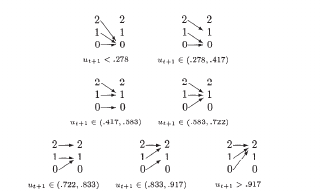




Given a random draw $u_{t+1} \sim U(0, 1)$, the paths from all possible starting points are described by Figure 13.1. This graph shows, in particular, that when $u_{t+1} > .917$, $u_{t+1} < .278$, or $u_{t+1} \in (.583, .722)$, the chain $X_t$ moves to the same value, whatever its previous value. These ranges of $u_{t+1}$ thus ensure coalescence in one step.

As in Accept-Reject algorithms, there is a seemingly difficult point with the random mapping representation

$$
\theta_t = \Psi_t(\theta_{t-1}) = \psi(\theta_{t-1}, u_t)
$$

of an MCMC transition when $\theta_t$ is generated using a random number of uniforms, because the vector $u_t$ has no predefined length. This difficulty is easily overcome, though, by modifying $\Psi$ into a function such that $u_t$ is the seed used in the pseudo-random generator at time $t$ (see Chapter 2). This eliminates the pretense of simulating, for each $t$, an infinite sequence of uniforms.

Random mappings are central to the coupling from the past scheme of Propp and Wilson (1996): if we find a time $T < 0$ such that the composition $\Psi_0 \circ \ldots \circ \Psi_T$ is constant, the value of the chain at time 0 is independent of the value of the chain at time $T$ and, by induction, of the value of the chain at time $-\infty$. In other words, if we formally start a chain at time $-\infty$, it will end up at time 0 with the same value no matter the starting value. Before establishing more rigorously the validity of Propp and Wilson's (1996) scheme, we first state a fundamental theorem of coupling.

**Theorem 13.2.** For a finite state space $\mathcal{X} = \{1, \ldots, k\}$, consider $k$ coupled Markov chains, $(\theta_1^{(t)}, (\theta_2^{(t)}, \ldots, (\theta_k^{(t)})$, where


(i) $\theta_0^{(j)} = j$;
(ii) $\theta_{t+1}^{(j)} = \Psi(x_t^{(j)}, u_{t+1})$, where the $U_t$'s are mutually independent.

Then the time $\tau$ to coalescence is a random variable that depends only on $U_1, U_2, \ldots$.

An interpretation of the coalescence time $\tau$ is that it is the time at which the initial state of the chain has "worn off": the distribution of $\theta_\tau^{(j)}$ is obviously the same for all $j$'s. A natural subsequent question is whether or not $\theta_\tau^{(j)}$ is a draw from the stationary distribution $\pi$. While it is the case that, for a fixed time $T^* > \tau$, $\theta_{T^*}^{(j)}$ is distributed from the stationary distribution, the fact that $\tau$ is a stopping time implies that $\theta_\tau^{(j)}$ is usually not distributed from $\pi$, as shown in Example 13.4 (see also Problems 13.1 and 13.2).

In [3]:
import random

def cftp_discrete(transition_matrix, max_time=20):
    """
    Implementation of Coupling From The Past for discrete state spaces.
    
    Args:
        transition_matrix: Transition probability matrix where P[i,j] is 
                          the probability of moving from state i to state j.
        max_time: Maximum number of time steps to go back.
        
    Returns:
        A sample from the stationary distribution of the Markov chain.
    """
    n_states = len(transition_matrix)
    
    # Create cumulative transition matrix for efficient sampling
    cum_trans_matrix = [[sum(transition_matrix[i][:j+1]) for j in range(n_states)] for i in range(n_states)]
    
    # Try increasingly longer chains until coalescence
    for t_max in [2**i for i in range(1, max_time)]:
        print(f"Attempting CFTP with t_max = {t_max}")
        
        # Generate random numbers for the update function
        random_numbers = [random.random() for _ in range(t_max)]
        
        # Initialize with all possible states
        x = list(range(n_states))
        
        # Simulate from -t_max to 0
        for t in range(t_max):
            # Update each state using the same random number
            u = random_numbers[t]
            x_new = [0] * n_states
            
            for i, state in enumerate(x):
                # Find the next state using the random number
                next_state = 0
                for j in range(n_states):
                  if u < cum_trans_matrix[state][j]:
                    next_state = j
                    break
                x_new[i] = next_state
            
            x = x_new
            
            # Check for coalescence
            if all(val == x[0] for val in x):
                print(f"Coalescence achieved at step {t+1}/{t_max}")
                if t < t_max - 1:
                    print("Early coalescence!")
                break
        
        # If all chains have coalesced to the same state, return it
        if all(val == x[0] for val in x):
            return x[0]
    
    raise Exception(f"No coalescence after {2**max_time} steps")

# Example 3-state Markov chain
P = [
    [0.7, 0.2, 0.1],
    [0.3, 0.4, 0.3],
    [0.1, 0.4, 0.5]
]

# Theoretical stationary distribution (for comparison)
def compute_stationary_distribution(P):
    n = len(P)
    eigenvalues, eigenvectors = [], []
    
    def matrix_transpose(matrix):
      return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

    def matrix_multiply(matrix1, matrix2):
      result = [[0 for _ in range(len(matrix2[0]))] for _ in range(len(matrix1))]
      for i in range(len(matrix1)):
        for j in range(len(matrix2[0])):
          for k in range(len(matrix2)):
            result[i][j] += matrix1[i][k] * matrix2[k][j]
      return result

    def vector_multiply(matrix, vector):
      result = [0 for _ in range(len(matrix))]
      for i in range(len(matrix)):
        for j in range(len(vector)):
          result[i] += matrix[i][j] * vector[j]
      return result

    def vector_length(vector):
        return sum(x*x for x in vector) ** 0.5

    def vector_normalize(vector):
        length = vector_length(vector)
        return [x/length for x in vector]

    def power_iteration(matrix, iterations=1000):
        vector = [random.random() for _ in range(len(matrix))]
        for _ in range(iterations):
            vector = vector_multiply(matrix, vector)
            vector = vector_normalize(vector)
        return vector

    PT = matrix_transpose(P)
    stationary = power_iteration(PT)
    return [x / sum(stationary) for x in stationary]

true_pi = compute_stationary_distribution(P)
print("True stationary distribution:", true_pi)

# Generate samples using CFTP
n_samples = 100
samples = []
for i in range(n_samples):
    if i % 10 == 0:
        print(f"Generating sample {i+1}/{n_samples}")
    samples.append(cftp_discrete(P))

# Compare empirical distribution with theoretical
empirical_dist = [samples.count(i) / n_samples for i in range(len(P))]
print("\nEmpirical distribution:", empirical_dist)

True stationary distribution: [0.4090909090909091, 0.31818181818181823, 0.27272727272727276]
Generating sample 1/100
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 3/4
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 1/2
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Attempting CFTP with t_max = 8
Coalescence achieved at step 2/8
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Coalescence achieved at step 2/4
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempting CFTP with t_max = 2
Coalescence achieved at step 1/2
Early coalescence!
Attempting CFTP with t_max = 2
Attempting CFTP with t_max = 4
Attempting CFTP with t_max = 8
Coalescence achieved at step 2/8
Early coalescence!
Attempting CFTP with t_max = 2
Coalescence achieved at step 2/2
Attempt